##Bibliografia

https://medium.com/trustyou-engineering/topic-modelling-with-pyspark-and-spark-nlp-a99d063f1a6e

https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/3.SparkNLP_Pretrained_Models.ipynb#scrollTo=qd-CX_39Iktn

https://pythonspot.com/nltk-stop-words/

https://monkeylearn.com/blog/text-cleaning/

https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/

https://nlp.johnsnowlabs.com/docs/en/annotators#ngramgenerator

https://nlp.johnsnowlabs.com/docs/en/transformers#finisher

https://medium.com/spark-nlp/applying-context-aware-spell-checking-in-spark-nlp-3c29c46963bc

https://www.linkedin.com/pulse/sentiment-analysis-pyspark-ricky-kim/

https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

https://python.hotexamples.com/es/examples/pyspark.ml.evaluation/MulticlassClassificationEvaluator/-/python-multiclassclassificationevaluator-class-examples.html?utm_content=cmp-true

##Librerias

In [0]:
!pip install sparknlp

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-e93ef15c-34b5-4e1b-8298-8c66d9d12298/bin/python -m pip install --upgrade pip' command.


In [0]:
import pandas as pd
import pyspark.sql.functions as F
import numpy as np
from keras_preprocessing.text import Tokenizer
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType, IntegerType
import re
from pyspark.ml import Pipeline
import nltk
nltk.download('stopwords')
import nltk
from nltk.corpus import stopwords
from sparknlp.annotator import Tokenizer, LemmatizerModel, DocumentAssembler, Stemmer, StopWordsCleaner, Normalizer, NorvigSweetingModel, BertEmbeddings, UniversalSentenceEncoder, WordEmbeddingsModel, SentenceEmbeddings, PerceptronModel, Chunker, NGramGenerator, ContextSpellCheckerModel
from sparknlp.base import Finisher
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
!python -m spacy download en_core_web_lg
!python -m spacy download en_core_web_sm

     |▏                               | 

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 12.8 MB 21.6 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-e93ef15c-34b5-4e1b-8298-8c66d9d12298/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


##Ejemplo de Uso

In [0]:
import spacy
nlp = spacy.load("en_core_web_sm")
vocabulary = ['hello','see','so','much']
for word in vocabulary:
  doc = nlp(word)
  for token in doc:
    print(token,token.lemma_, token.pos_,token.suffix_)

hello hello INTJ llo
see see VERB see
so so ADV so
much much ADV uch


In [0]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
Out[5]: True

In [0]:
from nltk.tokenize import word_tokenize
text = word_tokenize("boss bullying")
nltk.pos_tag(text)

Out[6]: [('boss', 'IN'), ('bullying', 'VBG')]

Conectamos a la Tabla

In [0]:
from NEAutils import Login
from delta import *
conn = Login(jefatura="ver",entorno="perf",spark=spark)
conn.NeaDLSP()

/databricks/python/lib/python3.9/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
log OK


In [0]:
df = spark.sql("SELECT * FROM dwbcptp8.data_teet")
#dropeamos features
coldrop = ['textID', 'selected_text']
df = df.drop(*coldrop)

In [0]:
df.summary().show()

+-------+--------------------+---------+
|summary|                text|sentiment|
+-------+--------------------+---------+
|  count|               31013|    27481|
|   mean|                null|     null|
| stddev|                null|     null|
|    min|\tREALLY?? oh.. s...| negative|
|    25%|                null|     null|
|    50%|                null|     null|
|    75%|                null|     null|
|    max|ï¿½ï¿½h. iï¿½m go...| positive|
+-------+--------------------+---------+



Eliminaremos los registros cuyas features contengan null, en el caso del Target es el que contiene el mayor numero de nulos y en el caso del text solo es un registro.

In [0]:
df = df.filter(F.col('sentiment').isNotNull() &  F.col('text').isNotNull())

##SCOPING

El objetico es indentificar a partir de la informacion procendente del texto la tipologia del mismo. Para este proyecto se contara con tres estados: 

* **Neutral**
* **Positive**
* **Negative**

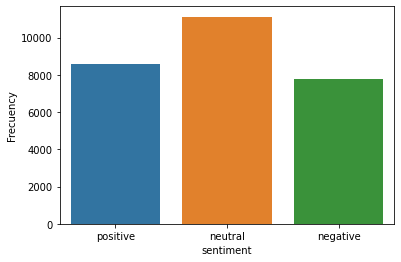

In [0]:
dftarget = df.groupBy('sentiment').agg(F.count('sentiment').alias('Frecuency')).toPandas()
_=sns.barplot(data=dftarget, x="sentiment", y="Frecuency")

## DATA

Se crearan funciones de spark para ir realizando la limpieza explicita de cada uno de los casos

In [0]:
@udf(returnType=StringType()) 
def cleantext(str):
  
  #Eliminamos las paginas web que haya en el texto
  html = re.compile(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''')
  str = html.sub('', str)

  #Eliminaamos los signos de puntacion que contenga el texto
  str = re.sub(r'[^\w\s]', '', str)
  
  #Eliminamos espacios por delante y por detras de
  str = str.strip()
  
  #Trasnformamos los textos a minusculas
  str = str.lower()
  
  #Eliminamos los numeros 
  str = re.sub(r'[0-9]+', '', str)
    
  return str

In [0]:
#Creamos los StopWwords para posteriormente utilizar la funcion de spark
stops = set(stopwords.words('english'))
stops = list(stops)

In [0]:
@udf(returnType=StringType()) 
def stopwords(str):
  """
  Las palabras vacías son palabras comunes dentro de las oraciones que no agregan valor y, por lo tanto, pueden eliminarse cuando se realiza una limpieza de NLP antes del análisis.
  """
  str = " ".join([value for value in str.split() if value not in (stops)])
  return str

In [0]:
@udf(returnType=StringType()) 
def cleaning_repeating_char(str):
  """
  Eliminamos las consonantes que se repiten unicamente que acaben en espacio.
  """
  return re.sub(r'(.)\D\1+', r'\1', str)

In [0]:
df = df.withColumn("text", cleantext(col("text")))
df = df.withColumn("text", stopwords(col("text")))
df = df.withColumn("text", cleaning_repeating_char(col("text")))


##PIPELINE PREPROCESADO DATOS

In [0]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("tokenized")

normalizer = Normalizer() \
     .setInputCols(['tokenized']) \
     .setOutputCol('normalized') \
     .setLowercase(True)

lemmatizer = LemmatizerModel.pretrained() \
     .setInputCols(['normalized']) \
     .setOutputCol('lemmatized')

spell_checker_norvig = NorvigSweetingModel.pretrained()\
                          .setInputCols("lemmatized")\
                          .setOutputCol("correct")

pipeline_pre = Pipeline() \
         .setStages([documentAssembler,
                 tokenizer,
                 normalizer,
                 lemmatizer,
                 spell_checker_norvig,
                    ])

empty_df_pre = spark.createDataFrame([['']]).toDF("text")
pipelineModel_pre = pipeline_pre.fit(empty_df_pre)
df2 = pipelineModel_pre.transform(df)
df2 = df2.select('correct.result','sentiment')
df2 = df2.withColumnRenamed('result','text')
df2 = df2.withColumn('text', F.concat_ws(' ', 'text'))

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[OK!]


##PIPELINE NGRAMS

In [0]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("tokenized")

pos_tagger = PerceptronModel.pretrained('pos_anc') \
     .setInputCols(['document', 'tokenized']) \
     .setOutputCol('pos')

#allowed_tags = ['<JJ>+<NN>','<NN>+<JJ>', '<NN>+<NN>','<JJ>+<JJ>','<RB>+<JJ>','<NN>+<VBG>', '<NN>+<VBP>+<RB>','<NN>+<RB>']
allowed_tags = ['<JJ>','<NN>+<JJ>', '<NN>+<NN>','<JJ>+<JJ>','<RB>+<JJ>','<NN>+<VBG>', '<NN>+<VBP>+<RB>','<NN>+<RB>']
#allowed_tags = ['<JJ>+<NN>','<RB>+<JJ>', '<IN>+<VBG>']
chunker = Chunker() \
     .setInputCols(['document', 'pos']) \
     .setOutputCol('ngrams') \
     .setRegexParsers(allowed_tags)

finisher = Finisher() \
     .setInputCols(['ngrams'])

pipeline = Pipeline() \
         .setStages([documentAssembler,
                     tokenizer,
                     pos_tagger,
                     chunker,
                      finisher])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = pipeline.fit(empty_df)
result = pipelineModel.transform(df2)

pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]


In [0]:
#Dropeamos los elementos vacios, estos vacios se ocasiona debido al procesado y filtrado que hay en el pipline
result = result.withColumn("size", F.size(F.col('finished_ngrams')))
#Filtramos unicamente los valores que no esten vacios
result = result.filter(F.col("size") >= 1)
final = result.select(['sentiment', 'finished_ngrams'])

##PIPELINE COUNTVECTORIZER Y VECTORIZACION

In [0]:
tfizer = CountVectorizer(inputCol='finished_ngrams',
                         outputCol='tf_features')

idfizer = IDF(inputCol='tf_features', 
              outputCol='features')

label_stringIdx = StringIndexer(inputCol = "sentiment",
                                outputCol = "label")

pipeline_countvect = Pipeline() \
         .setStages([tfizer,
                     idfizer,
                     label_stringIdx])

pipeline_countvectModel = pipeline_countvect.fit(final)
resultcontvect = pipeline_countvectModel.transform(final)


##MODELO MACHINE LEARNING

Seleccionamos las Features para el Modelo

In [0]:
fianl_label = resultcontvect.select('features','label')

Realizamos el split en train/test/val

In [0]:
(train_df, val_df, test_df) = fianl_label.randomSplit([0.98, 0.01, 0.01], seed = 2000)

Train del Modelo

In [0]:

lr = LogisticRegression(maxIter=100)
lrModel = lr.fit(train_df)
predictions = lrModel.transform(val_df)

##VALIDACION MODELO

In [0]:
evaluator = MulticlassClassificationEvaluator(
      labelCol="label", predictionCol="prediction", metricName="f1")
f1 = evaluator.evaluate(predictions)
print("F1 Score = %g" % (f1))

F1 Score = 0.939861


In [0]:
predictions['label','rawPrediction','prediction'].show(truncate=False)

+-----+-------------------------------------------------------------+----------+
|label|rawPrediction                                                |prediction|
+-----+-------------------------------------------------------------+----------+
|0.0  |[0.5057879817995994,-0.2930323773074897,-0.21275560449210965]|0.0       |
|1.0  |[0.5057879817995994,-0.2930323773074897,-0.21275560449210965]|0.0       |
|0.0  |[26.177556157947592,-21.892237711900727,-4.285318446046857]  |0.0       |
|1.0  |[-5.345545505717367,8.003912159394654,-2.658366653677286]    |1.0       |
|0.0  |[1.042051893779275,5.52681586196474,-6.568867755744012]      |1.0       |
|0.0  |[11.771247559078805,0.15118469667206264,-11.922432255750863] |0.0       |
|0.0  |[11.310376243024411,-1.8384551502458237,-9.471921092778587]  |0.0       |
|1.0  |[-2.5443835477786525,7.176063389229619,-4.631679841450968]   |1.0       |
|1.0  |[-4.96294740785175,13.170557376386922,-8.20760996853517]     |1.0       |
|1.0  |[-5.028747315839648,7